In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
import pandas as pd

# Load the dataset
file_path = '/content/Netflix Inc. (NFLX) Stock Price 2002-2025.csv'
data = pd.read_csv(file_path)

# Display the first few rows and the column names to inspect the structure
data.head(), data.columns


(           Date     Open       High       Low     Close Adj Close     Volume
 0  Feb 25, 2025     989.4     994.4       955    977.24    977.24  4,733,000
 1  Feb 24, 2025  1,008.00  1,015.17    984.48    988.47    988.47  4,426,200
 2  Feb 21, 2025  1,029.42  1,032.38    999.39  1,003.15  1,003.15  3,738,700
 3  Feb 20, 2025  1,042.00  1,045.00  1,015.59  1,024.54  1,024.54  3,111,800
 4  Feb 19, 2025  1,035.18  1,045.00  1,024.51  1,043.33  1,043.33  2,600,000,
 Index(['Date', 'Open ', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [56]:
# Drop rows with missing Date or Close values (as these are critical)
data = data.dropna(subset=['Date', 'Close']).reset_index(drop=True)

# Sort data by Date
data = data.sort_values('Date')

In [57]:
data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [58]:
# Remove any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Convert numerical columns from object to float
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Remove commas and convert to float, handling non-numeric values
for col in numeric_cols:
    # Replace non-numeric values with NaN
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')

# Verify the changes
print(data.dtypes)
print(data.head())


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
           Date  Open  High   Low  Close  Adj Close    Volume
5511 2003-04-01  1.46  1.47  1.33   1.35       1.35  17019800
5258 2004-04-01  5.16  5.17  4.81   5.05       5.05  38566500
5007 2005-04-01  1.56  1.57  1.54   1.55       1.55  10175200
4253 2008-04-01  5.07  5.27  4.91   5.22       5.22  16173500
4000 2009-04-01  6.11  6.28  6.02   6.12       6.12  10427900


In [59]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns for the model (using historical data only)
features = ['Open', 'High', 'Low',  'Adj Close', 'Volume']
target = 'Close'

# Scale the features and target for the model
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(data[features])
scaled_target = scaler_target.fit_transform(data[[target]])

# Define sequence length (number of past days to use for prediction)
sequence_length = 90

# Create sequences for input (X) and output (y)
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Past 'sequence_length' days
    y.append(scaled_target[i])  # Target price for the current day

X, y = np.array(X), np.array(y)

# Display the shape of the data for verification
X.shape, y.shape


((5637, 90, 5), (5637, 1))

In [62]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

def positional_encoding(sequence_length, feature_dim):
    """Generates positional encodings for time-series data with matching dimensions"""
    pos = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]  # (sequence_length, 1)
    i = tf.range(feature_dim, dtype=tf.float32)[tf.newaxis, :]  # (1, feature_dim)

    angles = pos / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(feature_dim, tf.float32))
    pos_encoding = tf.where(i % 2 == 0, tf.sin(angles), tf.cos(angles))

    return pos_encoding  # Shape: (sequence_length, feature_dim)

def build_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)  # (90, 5)

    # Generate positional encoding that matches input shape
    pos_encoding = positional_encoding(input_shape[0], input_shape[1])  # (90, 5)

    # Ensure the addition is properly broadcasted
    x = inputs + tf.expand_dims(pos_encoding, axis=0)  # Expand batch dimension to match input

    # Transformer Encoder Block (Stacking 2 blocks)
    for _ in range(2):  # Two stacked Transformer layers
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=5, dropout=0.1)(x, x)
        x = layers.Add()([x, attn_output])  # Residual Connection
        x = layers.LayerNormalization()(x)

        # Change the output dimension of the Dense layer to match the input shape
        ffn_output = layers.Dense(input_shape[1], activation='relu')(x)  # Now outputs (90, 5)
        ffn_output = layers.Dropout(0.2)(ffn_output)  # Regularization
        x = layers.Add()([x, ffn_output])  # Residual Connection
        x = layers.LayerNormalization()(x)

    # Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Model Configuration
model = build_transformer_model((90, 5))  # 90 timesteps, 5 features
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

# Early Stopping & Learning Rate Scheduler
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Model Summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 90, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 90, 5)          │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 90, 5)          │            465 │ add_6[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 90, 5)          │              0 │ add_6[0][0],           │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 90, 5)          │             10 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 90, 5)          │             30 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 90, 5)          │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 90, 5)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 90, 5)          │             10 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 90, 5)          │            465 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 90, 5)          │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 90, 5)          │             10 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 90, 5)          │             30 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 90, 5)          │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 90, 5)          │              0 │ layer_normalization_1… │
│                      

 Total params: 1,036 (4.05 KB)

 Trainable params: 1,036 (4.05 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
'''import tensorflow as tf
from tensorflow.keras import layers

def build_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inputs)

    # Transformer Encoder block
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_transformer_model((90, 5))  # 90 timesteps, 5 features
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
'''

"import tensorflow as tf\nfrom tensorflow.keras import layers\n\ndef build_transformer_model(input_shape):\n    inputs = layers.Input(shape=input_shape)\n    x = layers.LayerNormalization()(inputs)\n\n    # Transformer Encoder block\n    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)\n    x = layers.LayerNormalization()(x)\n    x = layers.Dense(64, activation='relu')(x)\n\n    # Pooling and output\n    x = layers.GlobalAveragePooling1D()(x)\n    outputs = layers.Dense(1)(x)\n\n    model = tf.keras.Model(inputs, outputs)\n    return model\n\nmodel = build_transformer_model((90, 5))  # 90 timesteps, 5 features\nmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])\nmodel.summary()\n"

In [67]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% each for validation and testing

# Define Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
)

# Train the Model
history = model.fit(
    X_train, y_train,  # Your training dataset
    validation_data=(X_val, y_val),  # Your validation dataset
    epochs=100,  # Set a high limit; early stopping will stop automatically
    batch_size=32,  # Adjust batch size based on GPU memory
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.1054 - mae: 0.2500 - val_loss: 0.0447 - val_mae: 0.1545 - learning_rate: 0.0010
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0483 - mae: 0.1771 - val_loss: 0.0411 - val_mae: 0.1556 - learning_rate: 0.0010
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0458 - mae: 0.1718 - val_loss: 0.0399 - val_mae: 0.1572 - learning_rate: 0.0010
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - loss: 0.0440 - mae: 0.1680 - val_loss: 0.0396 - val_mae: 0.1707 - learning_rate: 0.0010
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0444 - mae: 0.1717 - val_loss: 0.0409 - val_mae: 0.1505 - learning_rate: 0.0010
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0429 - mae: 0.1675 - val_loss: 0.0424 - val_mae: 0.1469 - learning_rate: 0.0010
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0440 - mae: 0.1642 - val_loss: 0.0387 - val_mae: 0.1548 - learnin

In [69]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict on the test set
predictions = model.predict(X_test)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0163 - mae: 0.0763
Test Loss: 0.014385806396603584, Test MAE: 0.07073131203651428
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


**Timestep 60**
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - mae: 0.0468
Test Loss: 0.0038598591927438974, Test MAE: 0.0469556599855423
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

**timesteps 50**

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - mae: 0.0504
Test Loss: 0.004411413799971342, Test MAE: 0.052888233214616776
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

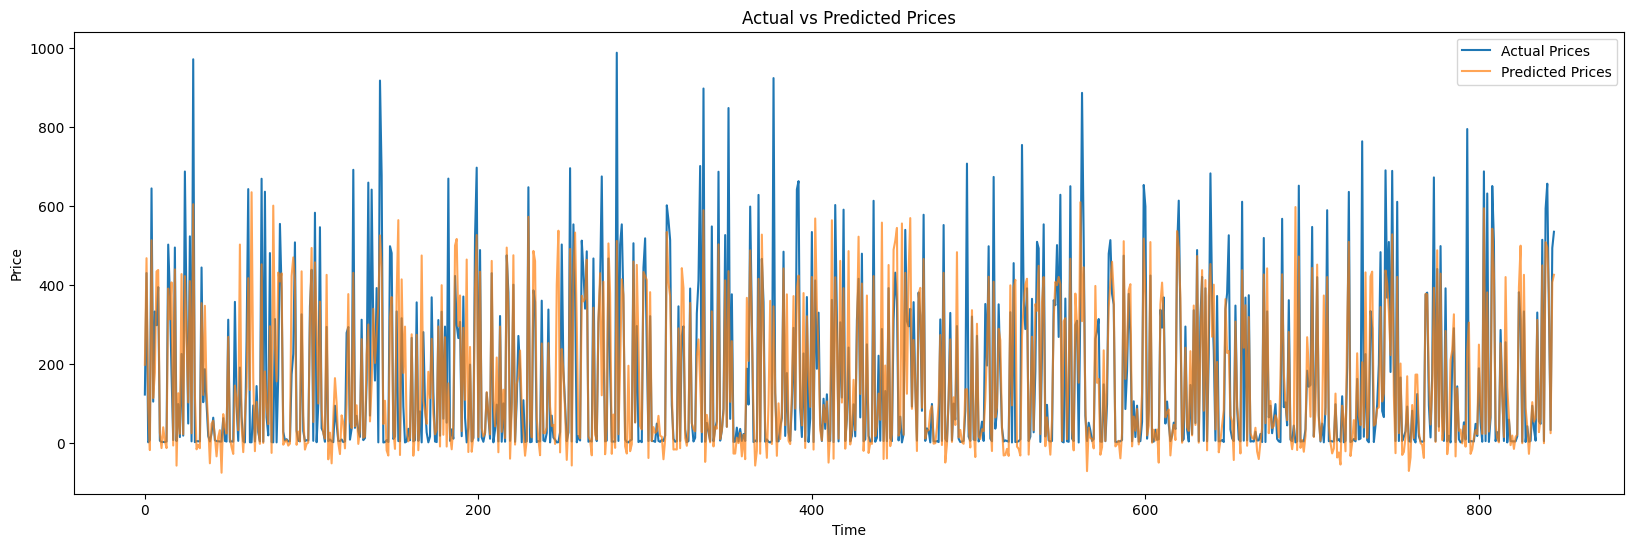

In [70]:
import matplotlib.pyplot as plt

# Rescale predictions and actual values back to original scale
predicted_prices = scaler_target.inverse_transform(predictions)
actual_prices = scaler_target.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(actual_prices, label="Actual Prices")
plt.plot(predicted_prices, label="Predicted Prices", alpha=0.7)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [71]:
# Get the latest 'sequence_length' days of features
latest_sequence = scaled_features[-sequence_length:]

# Reshape to match model input shape
latest_sequence = np.expand_dims(latest_sequence, axis=0)

# Predict the next day price
predicted_scaled_price = model.predict(latest_sequence)

# Inverse transform the predicted price to get the original value
predicted_price = scaler_target.inverse_transform(predicted_scaled_price)

print(f"The predicted price for the next day is: {predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The predicted price for the next day is: 91.14


In [72]:
import plotly.graph_objects as go

# Prepare data for the graph
historical_prices = scaler_target.inverse_transform(scaled_target)
time_steps = list(range(len(historical_prices)))
predicted_time_step = [len(historical_prices)]
predicted_price = scaler_target.inverse_transform(predicted_scaled_price)

# Create a Plotly figure
fig = go.Figure()

# Add historical prices to the graph
fig.add_trace(go.Scatter(
    x=time_steps,
    y=historical_prices.flatten(),
    mode='lines',
    name='Historical Prices',
    hovertemplate='Day: %{x}<br>Price: %{y:.2f}<extra></extra>'
))

# Add predicted price to the graph
fig.add_trace(go.Scatter(
    x=predicted_time_step,
    y=predicted_price.flatten(),
    mode='markers',
    name='Predicted Next Day Price',
    marker=dict(size=10, color='red'),
    hovertemplate='Predicted Day: %{x}<br>Price: %{y:.2f}<extra></extra>'
))

# Update graph layout
fig.update_layout(
    title="Stock Price Prediction",
    xaxis_title="Time (Days)",
    yaxis_title="Price",
    hovermode="x",
    template="plotly_white"
)

# Show the interactive graph
fig.show()
